In [1]:
### configuration
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.linalg as la

%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [2]:
# Enter the data
y =   \
     np.array([4,5,4,1,0,4,3,4,0,6,3,3,4,0,2,6,3,3,5,4,5,3,1,4,4,1,5,5,3,4,2,
            5,2,2,3,4,2,1,3,2,2,1,1,1,1,3,0,0,1,0,1,1,0,0,3,1,0,3,2,2,0,1,
            1,1,0,1,0,1,0,0,0,2,1,0,0,0,1,1,0,2,3,3,1,1,2,1,1,1,1,2,4,2,0,
            0,0,1,4,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1])

<Container object of 112 artists>

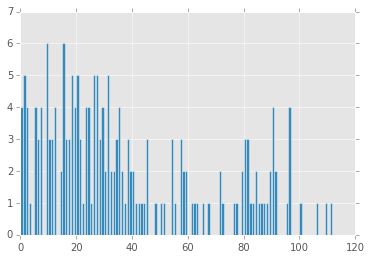

In [4]:
plt.ylim([0, 7])
plt.bar(np.arange(112), y)

In [106]:
### MCMC Sampling functions

# (1) Update S_n
def update_Sn(n, m, Ptran, theta, s):
    """ Update latent states S_n 
        Args: n - number of observation
              m - number of change point
              Ptran - Transition matrix
              theta - model parameters
              s - current state values for all time
        Return: F_lag - lag 1 predictive density
                F - posterior conditional density
                s_new - sampled latent states of length n """
    
    # read the current s values
    s_new = s
    
    # define quantities
    F_lag, F = np.zeros((n, m + 1)), np.zeros((n, m + 1))                                  
    F_lag[0, 0], F[0, 0] = 1, 1
    
    for i in range(1, n):
        for j in range(m + 1):
            F_lag[i,j] = (Ptran[:,j]).dot(F[i - 1,:])
        F[i,:] = F_lag[i,:] * stats.poisson.pmf(y[i], mu = theta)
        F[i,:] = F[i,:] / np.sum(F[i,:])
        
    # Sampling s_t
    for k in range(n - 2, 0, -1): # omit update s_n and s_1 because of their degeneracy
        pmfs = F[k,:] * Ptran[:,s_new[k + 1]]
        pmfs = pmfs / np.sum(pmfs)
        s_new[k] = np.random.choice(np.arange(m + 1), p = pmfs)
        
    return F_lag, F, s_new

# (2) Update P
def update_P(a, b, m, s, Ptran_star):
    """ Update transition matrix P 
        Args: a,b - prior beta parameters
              m - number of change points
              s - current sample of state
              Ptran_star - MLE of the transition matrix
        Return: nk - number of the same states
                Ptran - updated transition matrix 
                f_Ptran_star - marginal likelihood calculation involving Ptran """
    
    # define quantities
    nk = np.zeros(m + 1)
    Ptran = np.zeros((m + 1, m + 1))
    Ptran[-1, -1] = 1
    f = np.zeros(m)
    
    # number of same states
    for i in range(m + 1):
        nk[i] = np.sum(s == i)
    nii = nk - 1
    
    # update P
    for j in range(m):
        Ptran[j, j] = stats.beta.rvs(a + nii[j], b + 1)
        Ptran[j, j + 1] = 1.0 - Ptran[j, j]
        f[j] = stats.beta.pdf(Ptran_star[j, j], a + nii[j], b + 1)
    f_Ptran_star = np.prod(f)
    
    return nk, Ptran, f_Ptran_star

# (3) Update Theta - Poisson Model
def update_Theta(c, d, m, y, s, nk, theta_star):
    """ Update model parameters Theta 
        Args: c,d - prior gamma parameters
              m - number of change points
              y - vector of observations
              s - current sample of state
              nk - number of the same states
              theta_star - MLE of theta
        Return: theta - updated model parameters 
                f_theta_star - marginal likelihood calculation involving theta """
    
    # define quantities
    theta = np.repeat(2.0, m + 1)
    f = np.zeros(m + 1)
    
    # Update Theta
    for i in range(m + 1):
        uk = np.sum(y[s == i])
        theta[i] = stats.gamma.rvs(c + uk, scale = 1.0 / (d + nk[i]))
        f[i] = stats.gamma.pdf(theta_star[i], c + uk, scale = 1.0 / (d + nk[i]))
    f_theta_star = np.prod(f)
        
    return theta, f_theta_star

In [107]:
### Monte Carlo EM to compute the maximum likelihood estimates
def mcem_update(y, m):
    """ Finding the MLE by Monte Carlo Expectation Maximization
        Args: y - vector of observations
              m - number of change points
        Return: theta - MLE of model parameters
                Ptran - MLE of transition probabilities """
    
    # Initial parameters
    n = len(y)
    theta = np.repeat(2.0, m + 1)
    s = np.zeros(n - m)
    for i in range(1, m + 1):
        s = np.append(s, i)
    F_lag, F = np.zeros((n, m + 1)), np.zeros((n, m + 1))                                  
    F_lag[0, 0], F[0, 0] = 1, 1
    Ptran = np.zeros((m + 1, m + 1))
    Ptran[-1, -1] = 1
    for j in range(m):
        Ptran[j, j] = 0.5
        Ptran[j, j + 1] = 1 - Ptran[j, j]
    nk, uk = np.zeros(m + 1), np.zeros(m + 1)
    
    # Number of samples drawn to evaluate Q function
    N_seq = np.repeat(np.array([1, 100, 100, 100, 200, 200, 200, 300, 300, 300]), 10)
    nsim = N_seq.shape[0]
    
    # MECM updates
    np.random.seed(1234)
    for i in range(nsim):
        
        # E step
        ll_y, ll_s = 0.0, 0.0
        nk_sum, uk_sum = np.zeros(m + 1), np.zeros(m + 1)
        for j in range(N_seq[i]):
            F_lag, F, s = update_Sn(n, m, Ptran, theta, s)
            for k in range(m + 1):
                nk[k] = np.sum(s == k)
                uk[k] = np.sum(y[s == k])
            ll_y += np.sum(stats.poisson.logpmf(y, mu = theta[s.astype(int)]))
            ll_s += np.sum((nk - 1) * np.log(np.diag(Ptran))) + np.sum(np.log(1.0 - np.delete(np.diag(Ptran), -1)))
            nk_sum += nk
            uk_sum += uk
        Q_hat = (ll_y + ll_s) / float(N_seq[i])
    
        # M step
        theta = uk_sum / nk_sum
        for r in range(m):
            Ptran[r, r] = nk_sum[r] / (nk_sum[r] + N_seq[r])
            Ptran[r, r + 1] = 1.0 - Ptran[r, r]
            
        if(i % 20 == 0):
            print theta
            
    return theta, Ptran

In [128]:
### Execution Functions
def model_fit(y, m, vsim, burn, theta_star, Ptran_star, c, d):
    """ Update model parameters Theta 
        Args: y - vector of observations
              m - number of change points
              vsim - number of simulations in total
              burn - length of burn-in period
              theta_star - MLE of model parameters
              Ptran_star - MLE of transition probabilities
              c,d - prior gamma parameters
        Return: Theta_p - posterior samples of model parameters
                F_lag_sum, F_sum - posterior sums of marginal probs for latent states (need to average across simulations)
                log_f_y - maximized log-likelihood for a given model
                log_m - marginal likelihood for a given model """
    
    # priors
    n = len(y)
    a, b = 8., 0.1

    # Inits - parameters
    theta = np.repeat(2.0, m + 1)
    s = np.zeros(n - m)
    for i in range(1, m + 1):
        s = np.append(s, i)

    # Inits - useful quantities                           
    Ptran = np.zeros((m + 1, m + 1))
    Ptran[-1, -1] = 1
    for j in range(m):
        Ptran[j, j] = 0.5
        Ptran[j, j+1] = 1 - Ptran[j, j]

    # Store results
    Theta_p = np.zeros((vsim, m + 1))
    F_lag_sum, F_sum = np.zeros((n, m + 1)), np.zeros((n, m + 1))       
    F_theta_star, F_Ptran_star = np.zeros(vsim), np.zeros(vsim)

    np.random.seed(1234)
    # Gibbs steps
    for v in range(vsim):
        
        # Update S_n
        F_lag, F, s = update_Sn(n, m, Ptran, theta, s)
    
        # Update P
        nk, Ptran, f_Ptran_star = update_P(a, b, m, s, Ptran_star)
    
        # Update Theta
        theta, f_theta_star = update_Theta(c, d, m, y, s, nk, theta_star)

        # Save results
        Theta_p[v,:] = theta
        F_theta_star[v] = f_theta_star
        F_Ptran_star[v] = f_Ptran_star
    
        if(v >= burn):
            F_lag_sum = F_lag_sum + F_lag
            F_sum = F_sum + F
        if(v % 2000 == 0):
            print v
            
    ### compute marginal likelihood
    f_y = np.zeros((n, m + 1))
    for i in range(m + 1):
        f_y[:,i] = stats.poisson.pmf(y, mu = theta_star[i])
    F_lag_star, F_star, s_star = update_Sn(n, m, Ptran_star, theta_star, s)
    log_f_y = np.sum(np.log((f_y * F_lag_star).sum(axis = 1)))
    log_pi_theta_star = np.sum(stats.gamma.logpdf(theta_star, c, scale = 1.0 / d))
    log_pi_Ptran_star = np.sum(stats.beta.logpdf(np.delete(np.diag(Ptran_star), -1), a, b))
    log_f_theta_star = np.log(np.mean(F_theta_star[burn:]))
    log_f_Ptran_star = np.log(np.mean(F_Ptran_star[burn:]))
    log_m = log_f_y + log_pi_theta_star + log_pi_Ptran_star - log_f_theta_star - log_f_Ptran_star
    
    return Theta_p, F_lag_sum, F_sum, log_f_y, log_m

### Model with $0$ change point $M_0$

In [126]:
########################################################
######## M_0: Model with no change point ###############
########################################################
from math import lgamma, factorial
n, m = len(y), 0
c, d = 2.0, 1.0
y_bar = y.mean()
log_f_y_0 = np.sum(stats.poisson.logpmf(y, mu = y_bar))
log_m_0 = c*np.log(d) - (c + np.sum(y))*np.log(n + d) - np.sum(np.log(np.vectorize(factorial)(y))) + lgamma(c + np.sum(y)) - lgamma(c)
print "Maximized log-likelihood for M_0 is approximated as %.3f." % log_f_y_0
print "Marginal likelihood for M_0 is approximated as %.3f." % log_m_0

Maximized log-likelihood for M_0 is approximated as -203.858.
Marginal likelihood for M_0 is approximated as -206.207.


### Model with $1$ change point $M_1$

In [127]:
########################################################
######## M_1: Model with 1 change point ################
########################################################
n, m = len(y), 1
theta_star, Ptran_star = mcem_update(y, m)

[ 2.8     1.6542]
[ 3.1253  0.9239]
[ 3.1295  0.9262]
[ 3.1234  0.922 ]
[ 3.1194  0.9226]


In [129]:
vsim, burn = 7000, 1000
c, d = 2., 1.
Theta_p_1, F_lag_sum_1, F_sum_1, log_f_y_1, log_m_1 = model_fit(y, m, vsim, burn, theta_star, Ptran_star, c, d)

0
2000
4000
6000


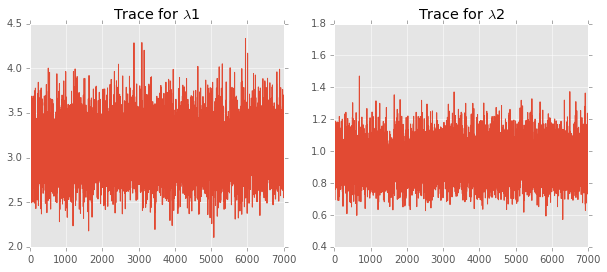

In [138]:
# MCMC diagnostics
plt.figure(figsize=(10, 4))
for i in range(m + 1):
    plt.subplot(1,2,i+1)
    plt.plot(Theta_p_1[:,i]);
    plt.title('Trace for $\lambda$%d' % (i+1))

posterior mean and standard deviation of lambda_1 are 3.099 and 0.290.
posterior mean and standard deviation of lambda_2 are 0.939 and 0.117.


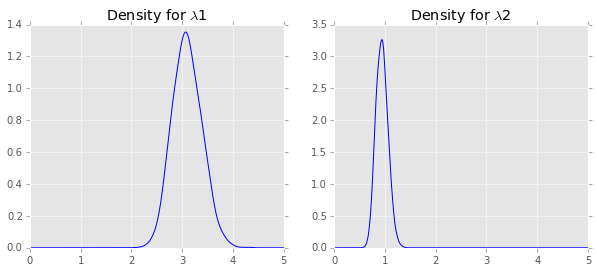

In [155]:
# density plots (reproduce the paper output)
plt.figure(figsize=(10, 4))
for i in range(m + 1):
    plt.subplot(1,2,i+1)
    density = stats.gaussian_kde(Theta_p_1[burn:,i])
    xs = np.linspace(0,5,500)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs), 'b')
    plt.title('Density for $\lambda$%d' % (i+1))

print "posterior mean and standard deviation of lambda_1 are %.3f and %.3f." %(np.mean(Theta_p_1[burn:,0]), np.std(Theta_p_1[burn:,0]))
print "posterior mean and standard deviation of lambda_2 are %.3f and %.3f." %(np.mean(Theta_p_1[burn:,1]), np.std(Theta_p_1[burn:,1])) 

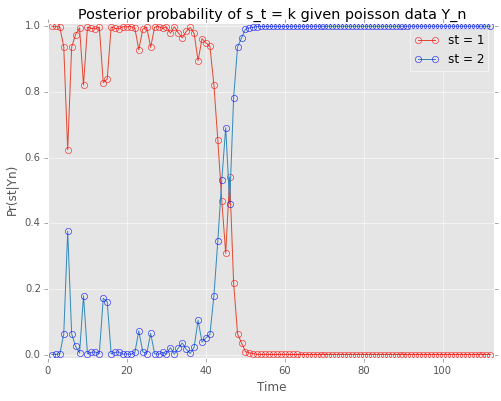

In [147]:
# Visualize change point for M_1
PrS = F_sum_1 / float(vsim - burn)
time = np.arange(1, n + 1)
plt.figure(figsize = (8, 6))
plt.plot(time, PrS[:,0], "o-", label = "st = 1", markerfacecolor = "none", markeredgecolor = "red")
plt.plot(time, PrS[:,1], "o-", label = "st = 2", markerfacecolor = "none", markeredgecolor = "blue")
plt.xlim([0, 113])
plt.ylim([-0.01, 1.01])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Pr(st|Yn)")
plt.title("Posterior probability of s_t = k given poisson data Y_n")

In [148]:
print "Maximized log-likelihood for M_1 is approximated as %.3f." % log_f_y_1
print "Marginal likelihood for M_1 is approximated as %.3f." % log_m_1

Maximized log-likelihood for M_1 is approximated as -176.896.
Marginal likelihood for M_1 is approximated as -178.380.


### Model with $2$ change points $M_2$

In [149]:
########################################################
######## M_2: Model with 2 change points ###############
########################################################
n, m = len(y), 2
theta_star, Ptran_star = mcem_update(y, m)

[ 4.3333  0.5     1.6542]
[ 3.2329  2.9586  0.92  ]
[ 3.214   2.9859  0.9199]
[ 3.2066  2.9846  0.9172]
[ 3.2106  2.9609  0.9188]


In [157]:
vsim, burn = 7000, 1000
c, d = 3., 1.
Theta_p_2, F_lag_sum_2, F_sum_2, log_f_y_2, log_m_2 = model_fit(y, m, vsim, burn, theta_star, Ptran_star, c, d)

0
2000
4000
6000


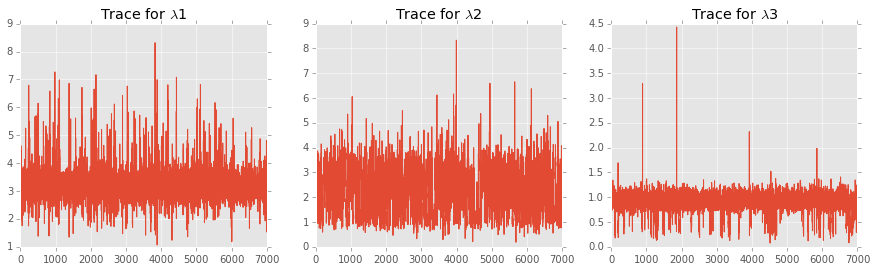

In [158]:
# MCMC diagnostics
plt.figure(figsize=(15, 4))
for i in range(m + 1):
    plt.subplot(1,3,i+1)
    plt.plot(Theta_p_2[:,i]);
    plt.title('Trace for $\lambda$%d' % (i+1))

posterior mean and standard deviation of lambda_1 are 3.220 and 0.545.
posterior mean and standard deviation of lambda_2 are 2.269 and 0.933.
posterior mean and standard deviation of lambda_3 are 0.885 and 0.211.


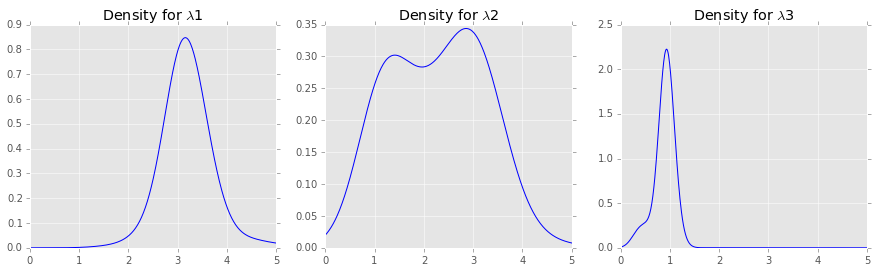

In [160]:
# density plots (reproduce the paper output)
plt.figure(figsize=(15, 4))
for i in range(m + 1):
    plt.subplot(1,3,i+1)
    density = stats.gaussian_kde(Theta_p_2[burn:,i])
    xs = np.linspace(0,5,500)
    density.covariance_factor = lambda : .5
    density._compute_covariance()
    plt.plot(xs,density(xs), 'b')
    plt.title('Density for $\lambda$%d' % (i+1))

print "posterior mean and standard deviation of lambda_1 are %.3f and %.3f." %(np.mean(Theta_p_2[burn:,0]), np.std(Theta_p_2[burn:,0]))
print "posterior mean and standard deviation of lambda_2 are %.3f and %.3f." %(np.mean(Theta_p_2[burn:,1]), np.std(Theta_p_2[burn:,1]))
print "posterior mean and standard deviation of lambda_3 are %.3f and %.3f." %(np.mean(Theta_p_2[burn:,2]), np.std(Theta_p_2[burn:,2])) 

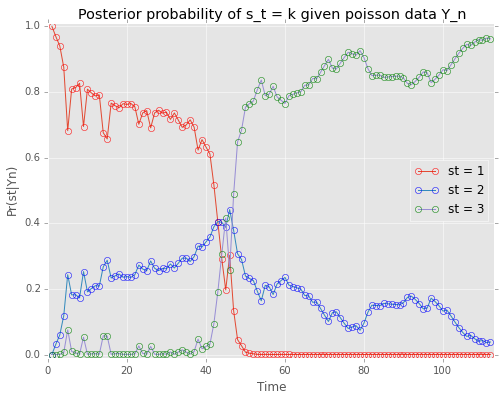

In [162]:
# Visualize change point for M_2
PrS = F_sum_2 / float(vsim - burn)
time = np.arange(1, n + 1)
plt.figure(figsize = (8, 6))
plt.plot(time, PrS[:,0], "o-", label = "st = 1", markerfacecolor = "none", markeredgecolor = "red")
plt.plot(time, PrS[:,1], "o-", label = "st = 2", markerfacecolor = "none", markeredgecolor = "blue")
plt.plot(time, PrS[:,2], "o-", label = "st = 3", markerfacecolor = "none", markeredgecolor = "green")
plt.xlim([0, 113])
plt.ylim([-0.01, 1.01])
plt.legend(loc = "best")
plt.xlabel("Time")
plt.ylabel("Pr(st|Yn)")
plt.title("Posterior probability of s_t = k given poisson data Y_n")

In [163]:
print "Maximized log-likelihood for M_2 is approximated as %.3f." % log_f_y_2
print "Marginal likelihood for M_2 is approximated as %.3f." % log_m_2

Maximized log-likelihood for M_2 is approximated as -181.196.
Marginal likelihood for M_2 is approximated as -180.630.
